In [1]:
# Upgrade Oracle ADS to pick up the latest preview version to maintain compatibility with Oracle Cloud Infrastructure.

!odsc conda install --uri https://objectstorage.us-ashburn-1.oraclecloud.com/p/qnzzHQPGQYghdyH206yDk25MZH1FaMGdNNhKUl74BhRsW4muvFyGViKIqpxgnxI3/n/ociodscdev/b/ads_conda_pack_builds/o/PySpark_3/teamcity_20230512_084146_38972446/f227145b7ee5fc1c73a69ebaa671b81e/PySpark_3.2_and_Feature_Store.tar.gz

zsh:1: command not found: odsc


Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Feature store handling querying operations</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
Managing many datasets, data-sources and transformations for machine learning is complex and costly. Poorly cleaned data, data issues, bugs in transformations, data drift and training serving skew all leads to increased model development time and worse model performance. Here, feature store is well positioned to solve many of the problems since it provides a centralised way to transform and access data for training and serving time and helps defines a standardised pipeline for ingestion of data and querying of data. This notebook demonstrates how to use feature store within a long lasting [Oracle Cloud Infrastructure Data Flow](https://docs.oracle.com/en-us/iaas/data-flow/using/home.htm) cluster.

Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>2.1 Policies</a>
    - <a href='#prerequisites_authentication'>2.2 Authentication</a>
    - <a href='#prerequisites_variables'>2.3 Variables</a>
- <a href='#featurestore_querying'>3. Feature store querying</a>
    - <a href='#load_featuregroup'>3.1. Load feature groups</a>
    - <a href='#explore_featuregroup'>3.2. Explore feature groups</a>
    - <a href='#select_subset_featuregroup'>3.3. Select subset of features</a>
    - <a href='#explore_featuregroup'>3.4. Explore feature groups</a>
    - <a href='#filter_featuregroup'>3.5. Filter feature groups</a>
    - <a href='#create_dataset'>3.6. Create dataset from multiple or one feature group</a>
    - <a href='#query_dataset'>3.7 Query dataset</a>
- <a href='#ref'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id="concepts"></a>
# 1. Introduction

Oracle feature store is a stack based solution that is deployed in the customer enclave using OCI resource manager. Customer can stand up the service with infrastructure in their own tenancy. The service consists of API which are deployed in customer tenancy using resource manager.

The following are some key terms that will help you understand OCI Data Science Feature Store:


* **Feature Vector**: Set of feature values for any one primary/identifier key. Eg.  All/subset of  features of customer id '2536' can be called as one feature vector.
* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.
* **Entity**: An entity is a group of semantically related features.
* **Datasource**: Features are engineered from raw data stored in various data sources (e.g. object storage, Oracle Database, Oracle MySQL, etc).
* **Feature Group** - A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.
* **Dataset**: Datasets are created from features stored in the feature store service and are used to train models and to perform online model inference.

<a id='pre-requisites'></a>
# 2. Pre-requisites

Data Flow Sessions are accessible through the following conda environment:

* **PySpark 3.2, Feature store 1.0 and Data Flow 1.0 (pyspark32_p38_cpu_feature_store_v1)**

The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage. You can customize `pyspark32_p38_cpu_feature_store_v1`, publish it, and use it as a runtime environment for a Data Flow session cluster. The metastore id of hive metastore is tied to feature store construct of feature store service.

<a id='policies'></a>
### 2.1. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

<a id="prerequisites_authentication"></a>
### 2.2. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook cluster.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [2]:
import ads
ads.set_auth(auth="api_key", client_kwargs={"service_endpoint": "http://localhost:21000/20230101"})

<a id="prerequisites_variables"></a>
### 2.3. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and bucket `<metastore_id>` for offline feature store.

In [3]:
import os

compartment_id = "ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa"
metastore_id = "ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxyap7tizm4gscwz7amu7dixz7ml3mtesqzzwwg3urvvdgua"

<a id="featurestore_querying"></a>
# 3. Feature group querying
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) and [deeque](https://github.com/awslabs/deequ) libraries. The joining functionality is heavily inspired by the APIs used by Pandas to merge, join or filter DataFrames. The APIs allow you to specify which features to select from which feature group, how to join them and which features to use in join conditions.

In [4]:
import warnings
warnings.filterwarnings("ignore", message="iteritems is deprecated")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode

from ads.feature_store.feature_group_expectation import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  warnings.warn(

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

ERROR:logger:Please set env variable SPARK_VERSION
INFO:logger:Using deequ: com.amazon.deequ:deequ:1.2.2-spark-3.0


<a id="data_exploration"></a>
### 3.1. Exploration of data in feature store

In [6]:
flights_df = pd.read_csv("~/Downloads/flights.csv",nrows=100)[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
flights_df = flights_df.head(100)
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,2015,1,1,4,AS,98,ANC,SEA
1,2015,1,1,4,AA,2336,LAX,PBI
2,2015,1,1,4,US,840,SFO,CLT
3,2015,1,1,4,AA,258,LAX,MIA
4,2015,1,1,4,AS,135,SEA,ANC


In [7]:
airports_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airports.csv")
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [8]:
airlines_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airlines.csv")
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


<a id="load_featuregroup"></a>
### 3.2. Create feature store logical entities

#### 3.2.1 Feature Store
Feature store is the top level entity for feature store service

In [9]:
feature_store_resource = (
    FeatureStore().
    with_description("Data consisting of flights").
    with_compartment_id(compartment_id).
    with_display_name("flights details").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [10]:
feature_store = feature_store_resource.create()
feature_store


kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Data consisting of flights
  displayName: flights details
  id: 12CC69323C61BD5E3CB868F0776055F0
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxyap7tizm4gscwz7amu7dixz7ml3mtesqzzwwg3urvvdgua
type: featureStore

#### 3.2.2 Entity
An entity is a group of semantically related features.

In [11]:
entity = feature_store.create_entity(
    display_name="Flight details2",
    description="description for flight details"
)
entity


kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: description for flight details
  featureStoreId: 12CC69323C61BD5E3CB868F0776055F0
  id: 589E6D7C5256BC5D35502EA34070802A
  name: Flight details2
type: entity

#### 3.2.3 Feature group
A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.

<a id="create_feature_group_flights"></a>
##### Flights Feature Group

Create feature group for flights

In [12]:
feature_group_flights = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["FLIGHT_NUMBER"])
    .with_name("flights_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(flights_df)
)

In [13]:
feature_group_flights.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 589E6D7C5256BC5D35502EA34070802A
  featureStoreId: 12CC69323C61BD5E3CB868F0776055F0
  id: 4096F2264D2ADD241320A2CC590A7C71
  inputFeatureDetails:
  - featureType: INTEGER
    name: YEAR
    orderNumber: 1
  - featureType: INTEGER
    name: MONTH
    orderNumber: 2
  - featureType: INTEGER
    name: DAY
    orderNumber: 3
  - featureType: INTEGER
    name: DAY_OF_WEEK
    orderNumber: 4
  - featureType: STRING
    name: AIRLINE
    orderNumber: 5
  - featureType: INTEGER
    name: FLIGHT_NUMBER
    orderNumber: 6
  - featureType: STRING
    name: ORIGIN_AIRPORT
    orderNumber: 7
  - featureType: STRING
    name: DESTINATION_AIRPORT
    orderNumber: 8
  name: flights_feature_group
  primaryKeys:
    items:
    - name: FLIGHT_NUMBER
  statisticsConfig:
    isEnabled: true
type: featureGroup

In [14]:
!export PATH="/usr/local/opt/graphviz/bin:$PATH"

In [15]:
!pip install graphviz==0.16

Looking in indexes: https://pypi.python.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/Users/kshitizlohia/IdeaProjects/oracle/feature-store/advanced-ds/venv/bin/python -m pip install --upgrade pip' command.


  from IPython.core.display import display



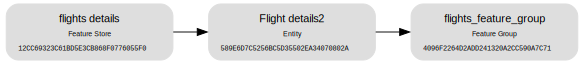

In [16]:
feature_group_flights.show()

In [17]:
os.environ["DEVELOPER_MODE"] = "True"

In [18]:
feature_group_flights.materialise(flights_df)

:: loading settings :: url = jar:file:/Users/kshitizlohia/IdeaProjects/oracle/feature-store/advanced-ds/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/kshitizlohia/.ivy2/cache
The jars for the packages stored in: /Users/kshitizlohia/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7b3e3ceb-2f7f-4f73-b111-bc7215cca45b;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.3.0 in central
	found io.delta#delta-storage;2.3.0 in central
	found org.antlr#antlr4-runtime;4.8 in local-m2-cache
:: resolution report :: resolve 257ms :: artifacts dl 8ms
	:: modules in use:
	io.delta#delta-core_2.12;2.3.0 from central in [default]
	io.delta#delta-storage;2.3.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from local-m2-cache in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      defau

23/05/26 18:26:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):



23/05/26 18:27:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/05/26 18:27:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/05/26 18:27:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/05/26 18:27:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/05/26 18:27:10 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `589e6d7c5256bc5d35502ea34070802a`.`flights_feature_group` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


<a id="create_feature_group_airport"></a>
##### Airport Feature Group

Create feature group for airport

In [19]:
expectation_suite_airports = ExpectationSuite(
    expectation_suite_name="test_airports_df"
)
expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "IATA_CODE"},
    )
)

{"kwargs": {"column": "IATA_CODE"}, "meta": {}, "expectation_type": "expect_column_values_to_not_be_null"}

In [20]:
feature_group_airports = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["IATA_CODE"])
    .with_name("airport_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(airports_df)
    .with_expectation_suite(
        expectation_suite=expectation_suite_airports,
        expectation_type=ExpectationType.STRICT,
     )
)

In [21]:
feature_group_airports.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 589E6D7C5256BC5D35502EA34070802A
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    expectationType: STRICT
    name: test_airports_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 12CC69323C61BD5E3CB868F0776055F0
  id: 5D11B87EB3AEAE6815CC0328DB20430C
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - featureType: STRING
    name: AIRPORT
    orderNumber: 2
  - featureType: STRING
    name: CITY
    orderNumber: 3
  - featureType: STRING
    name: STATE
    orderNumber: 4
  - featureType: STRING
    name: COUNTRY
    orderNumber: 5
  - featureType: FLOAT
    name: LATITUDE
    orderNumber: 6
  - featureType: FLOAT
    name: LONGITUDE
    orderNumber: 7
  name: airp

In [22]:
feature_group_airports.materialise(airports_df)

INFO:great_expectations.validator.validator:	1 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

23/05/26 18:28:09 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/05/26 18:28:09 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/05/26 18:28:09 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/05/26 18:28:13 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `589e6d7c5256bc5d35502ea34070802a`.`airport_feature_group` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


In [23]:
# feature_group_airports.show()

<a id="create_feature_group_airlines"></a>
##### Airlines Feature Group

Create feature group for airlines

![FeatureGroup](https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_groups.gif "fetaure_groups")

In [24]:
expectation_suite_airlines = ExpectationSuite(
    expectation_suite_name="test_airlines_df"
)
expectation_suite_airlines.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "IATA_CODE"},
    )
)

{"kwargs": {"column": "IATA_CODE"}, "meta": {}, "expectation_type": "expect_column_values_to_not_be_null"}

In [25]:
feature_group_airlines = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["IATA_CODE"])
    .with_name("airlines_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(airlines_df)
    .with_expectation_suite(
        expectation_suite=expectation_suite_airlines,
        expectation_type=ExpectationType.STRICT,
     )
)

In [26]:
feature_group_airlines.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 589E6D7C5256BC5D35502EA34070802A
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    expectationType: STRICT
    name: test_airlines_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 12CC69323C61BD5E3CB868F0776055F0
  id: DB2095CF4B3D03D32DA206C020DF49D8
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - featureType: STRING
    name: AIRLINE
    orderNumber: 2
  name: airlines_feature_group
  primaryKeys:
    items:
    - name: IATA_CODE
  statisticsConfig:
    isEnabled: true
type: featureGroup

In [27]:
feature_group_airlines.materialise(airlines_df)

INFO:great_expectations.validator.validator:	1 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

23/05/26 18:29:09 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `589e6d7c5256bc5d35502ea34070802a`.`airlines_feature_group` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


In [28]:
# feature_group_airlines.show()

<a id="explore_featuregroup"></a>
### 3.3. Explore feature groups

In [29]:
feature_group_flights.get_features_df()

,name,type,feature_group_id
0,YEAR,LONG,4096F2264D2ADD241320A2CC590A7C71
1,MONTH,LONG,4096F2264D2ADD241320A2CC590A7C71
2,DAY,LONG,4096F2264D2ADD241320A2CC590A7C71
3,DAY_OF_WEEK,LONG,4096F2264D2ADD241320A2CC590A7C71
4,AIRLINE,STRING,4096F2264D2ADD241320A2CC590A7C71
5,FLIGHT_NUMBER,LONG,4096F2264D2ADD241320A2CC590A7C71
6,ORIGIN_AIRPORT,STRING,4096F2264D2ADD241320A2CC590A7C71
7,DESTINATION_AIRPORT,STRING,4096F2264D2ADD241320A2CC590A7C71


In [30]:
feature_group_airports.get_features_df()

,name,type,feature_group_id
0,IATA_CODE,STRING,5D11B87EB3AEAE6815CC0328DB20430C
1,AIRPORT,STRING,5D11B87EB3AEAE6815CC0328DB20430C
2,CITY,STRING,5D11B87EB3AEAE6815CC0328DB20430C
3,STATE,STRING,5D11B87EB3AEAE6815CC0328DB20430C
4,COUNTRY,STRING,5D11B87EB3AEAE6815CC0328DB20430C
5,LATITUDE,DOUBLE,5D11B87EB3AEAE6815CC0328DB20430C
6,LONGITUDE,DOUBLE,5D11B87EB3AEAE6815CC0328DB20430C


In [31]:
feature_group_airlines.get_features_df()

,name,type,feature_group_id
0,IATA_CODE,STRING,DB2095CF4B3D03D32DA206C020DF49D8
1,AIRLINE,STRING,DB2095CF4B3D03D32DA206C020DF49D8


In [32]:
feature_group_flights.select().show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+
|2015|    1|  1|          4|     DL|         1450|           LAS|                MSP|
|2015|    1|  1|          4|     UA|         1545|           LAX|                IAH|
|2015|    1|  1|          4|     AS|          130|           FAI|                SEA|
|2015|    1|  1|          4|     NK|          597|           MSP|                FLL|
|2015|    1|  1|          4|     US|          413|           LAS|                CLT|
|2015|    1|  1|          4|     AA|         2392|           DEN|                MIA|
|2015|    1|  1|          4|     NK|          168|           PHX|                ORD|
|2015|    1|  1|          4|     AA|         2211|           PHX|                MIA|
|2015|    1|  1|          4|     AS|          136|    

In [33]:
feature_group_airports.select().show()

+---------+--------------------+-------------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|         CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-------------+-----+-------+--------+----------+
|      MGM|Montgomery Region...|   Montgomery|   AL|    USA|32.30064| -86.39398|
|      MHK|Manhattan Regiona...|    Manhattan|   KS|    USA|39.14097| -96.67083|
|      MHT|Manchester-Boston...|   Manchester|   NH|    USA|42.93452| -71.43706|
|      MIA|Miami Internation...|        Miami|   FL|    USA|25.79325| -80.29056|
|      MKE|General Mitchell ...|    Milwaukee|   WI|    USA|42.94722| -87.89658|
|      MKG|Muskegon County A...|     Muskegon|   MI|    USA|43.16949| -86.23822|
|      MLB|Melbourne Interna...|    Melbourne|   FL|    USA|28.10275| -80.64581|
|      MLI|Quad City Interna...|       Moline|   IL|    USA|41.44853| -90.50754|
|      MLU|Monroe Regional A...|       Monroe|   LA|    USA|32.51087| -92.03769|
|      MMH|Mammoth Yosemite 

In [34]:
feature_group_airlines.select().show()

+---------+--------------------+
|IATA_CODE|             AIRLINE|
+---------+--------------------+
|       EV|Atlantic Southeas...|
|       HA|Hawaiian Airlines...|
|       UA|United Air Lines ...|
|       MQ|American Eagle Ai...|
|       VX|      Virgin America|
|       WN|Southwest Airline...|
|       DL|Delta Air Lines Inc.|
|       OO|Skywest Airlines ...|
|       AS|Alaska Airlines Inc.|
|       AA|American Airlines...|
+---------+--------------------+
only showing top 10 rows



In [35]:
feature_group_airlines.get_statistics().to_pandas()

,IATA_CODE,AIRLINE
completeness,1.0,1.0
approximateNumDistinctValues,13,14
dataType,String,String


In [36]:
feature_group_flights.get_statistics().to_pandas()

,DAY,FLIGHT_NUMBER,AIRLINE,ORIGIN_AIRPORT,DAY_OF_WEEK,MONTH,YEAR,DESTINATION_AIRPORT
completeness,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
approximateNumDistinctValues,1,95,11,42,1,1,1,29
dataType,Integral,Integral,String,String,Integral,Integral,Integral,String
sum,100.0,171151.0,NaN,NaN,400.0,100.0,201500.0,NaN
min,1.0,17.0,NaN,NaN,4.0,1.0,2015.0,NaN
max,1.0,7419.0,NaN,NaN,4.0,1.0,2015.0,NaN
mean,1.0,1711.51,NaN,NaN,4.0,1.0,2015.0,NaN
stddev,0.0,1873.257011,NaN,NaN,0.0,0.0,0.0,NaN


In [37]:
feature_group_flights.get_statistics()


kind: statistics
spec:
  content: '{"DAY": {"completeness": 1.0, "approximateNumDistinctValues": 1, "dataType":
    "Integral", "sum": 100.0, "min": 1.0, "max": 1.0, "mean": 1.0, "stddev": 0.0},
    "FLIGHT_NUMBER": {"completeness": 1.0, "approximateNumDistinctValues": 95, "dataType":
    "Integral", "sum": 171151.0, "min": 17.0, "max": 7419.0, "mean": 1711.51, "stddev":
    1873.257011170651}, "AIRLINE": {"completeness": 1.0, "approximateNumDistinctValues":
    11, "dataType": "String"}, "ORIGIN_AIRPORT": {"completeness": 1.0, "approximateNumDistinctValues":
    42, "dataType": "String"}, "DAY_OF_WEEK": {"completeness": 1.0, "approximateNumDistinctValues":
    1, "dataType": "Integral", "sum": 400.0, "min": 4.0, "max": 4.0, "mean": 4.0,
    "stddev": 0.0}, "MONTH": {"completeness": 1.0, "approximateNumDistinctValues":
    1, "dataType": "Integral", "sum": 100.0, "min": 1.0, "max": 1.0, "mean": 1.0,
    "stddev": 0.0}, "YEAR": {"completeness": 1.0, "approximateNumDistinctValues":
    

In [38]:
feature_group_airlines.get_validation_output_df().T

,0
results,"[{'success': True, 'exception_info': {'raised_exception': False, 'exception_traceback': None, 'exception_message': None}, 'result': {'element_count': 14, 'unexpected_count': 0, 'unexpected_percent': 0.0, 'partial_unexpected_list': []}, 'meta': {}, 'expectation_config': {'kwargs': {'column': 'IATA_CODE', 'batch_id': 'fcc0fd82abbd5135e99c8e9bb6de9a40'}, 'meta': {}, 'expectation_type': 'expect_column_values_to_not_be_null'}}]"
success,True
statistics.evaluated_expectations,1
statistics.successful_expectations,1
statistics.unsuccessful_expectations,0
statistics.success_percent,100.0
meta.great_expectations_version,0.16.10
meta.expectation_suite_name,airlines_feature_group
meta.run_id.run_time,2023-05-26T18:29:06.748389+05:30
meta.run_id.run_name,None


In [39]:
feature_group_airports.get_validation_output_df().T

,0
results,"[{'success': True, 'exception_info': {'raised_exception': False, 'exception_traceback': None, 'exception_message': None}, 'result': {'element_count': 322, 'unexpected_count': 0, 'unexpected_percent': 0.0, 'partial_unexpected_list': []}, 'meta': {}, 'expectation_config': {'kwargs': {'column': 'IATA_CODE', 'batch_id': '178b8ab97302e0239a456245bd5396df'}, 'meta': {}, 'expectation_type': 'expect_column_values_to_not_be_null'}}]"
success,True
statistics.evaluated_expectations,1
statistics.successful_expectations,1
statistics.unsuccessful_expectations,0
statistics.success_percent,100.0
meta.great_expectations_version,0.16.10
meta.expectation_suite_name,airport_feature_group
meta.run_id.run_time,2023-05-26T18:28:08.605417+05:30
meta.run_id.run_name,None


<a id="select_subset_featuregroup"></a>
### 3.4. Select subset of features

In [40]:
feature_group_airlines.select(['IATA_CODE']).show()

+---------+
|IATA_CODE|
+---------+
|       EV|
|       HA|
|       UA|
|       MQ|
|       VX|
|       WN|
|       DL|
|       OO|
|       AS|
|       AA|
+---------+
only showing top 10 rows



<a id="filter_featuregroup"></a>
### 3.5. Filter feature groups

In [41]:
feature_group_airlines.filter(feature_group_airlines.IATA_CODE == "EV").show()

+---------+--------------------+
|IATA_CODE|             AIRLINE|
+---------+--------------------+
|       EV|Atlantic Southeas...|
+---------+--------------------+



<a id="join_featuregroup"></a>
### 3.6. Apply joins on feature group
As in Pandas, if the feature has the same name on both feature groups, then you can use the `on=[]` paramter. If they have different names, then you can use the `left_on=[]` and `right_on=[]` paramters:

In [42]:
from ads.feature_store.common.enums import JoinType

query = (
    feature_group_flights.select()
    .join(feature_group_airlines.select(), left_on=['ORIGIN_AIRPORT'], right_on=['IATA_CODE'], join_type=JoinType.LEFT)
    .join(feature_group_airports.select(), left_on=['AIRLINE'], right_on=['IATA_CODE'], join_type=JoinType.LEFT)
)
query.show(5)

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|AIRPORT|CITY|STATE|COUNTRY|LATITUDE|LONGITUDE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|2015|    1|  1|          4|     DL|         1450|           LAS|                MSP|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     UA|         1545|           LAX|                IAH|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     AS|          130|           FAI|                SEA|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     NK|          597|           MSP|                FLL|     null|   null|null| null|   null|    null|     null|
|2015|

In [43]:
query.to_string()

'SELECT fg_2.YEAR YEAR, fg_2.MONTH MONTH, fg_2.DAY DAY, fg_2.DAY_OF_WEEK DAY_OF_WEEK, fg_2.AIRLINE AIRLINE, fg_2.FLIGHT_NUMBER FLIGHT_NUMBER, fg_2.ORIGIN_AIRPORT ORIGIN_AIRPORT, fg_2.DESTINATION_AIRPORT DESTINATION_AIRPORT, fg_0.IATA_CODE IATA_CODE, fg_1.AIRPORT AIRPORT, fg_1.CITY CITY, fg_1.STATE STATE, fg_1.COUNTRY COUNTRY, fg_1.LATITUDE LATITUDE, fg_1.LONGITUDE LONGITUDE FROM `589E6D7C5256BC5D35502EA34070802A`.flights_feature_group fg_2 LEFT JOIN `589E6D7C5256BC5D35502EA34070802A`.airlines_feature_group fg_0 ON fg_2.ORIGIN_AIRPORT = fg_0.IATA_CODE LEFT JOIN `589E6D7C5256BC5D35502EA34070802A`.airport_feature_group fg_1 ON fg_2.AIRLINE = fg_1.IATA_CODE'

<a id="create_dataset"></a>
### 3.7 Create dataset
A dataset is a collection of feature snapshots that are joined together to either train a model or perform model inference.

![Dataset](https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/dataset.gif "dataset")


In [44]:
dataset = (
    Dataset()
    .with_description("Combined dataset for flights")
    .with_compartment_id(compartment_id)
    .with_name("flights_dataset")
    .with_entity_id(entity.id)
    .with_feature_store_id(feature_store.id)
    .with_query(query.to_string())
)

<a id="create_dataset"></a>
##### Create Dataset

Call the ```.create()``` method of the Dataset instance to create a dataset.

In [45]:
dataset.create()


kind: Dataset
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Combined dataset for flights
  entityId: 589E6D7C5256BC5D35502EA34070802A
  featureStoreId: 12CC69323C61BD5E3CB868F0776055F0
  id: 6E66506E563042B3324B81DBACD51189
  name: flights_dataset
  query: SELECT fg_2.YEAR YEAR, fg_2.MONTH MONTH, fg_2.DAY DAY, fg_2.DAY_OF_WEEK DAY_OF_WEEK,
    fg_2.AIRLINE AIRLINE, fg_2.FLIGHT_NUMBER FLIGHT_NUMBER, fg_2.ORIGIN_AIRPORT ORIGIN_AIRPORT,
    fg_2.DESTINATION_AIRPORT DESTINATION_AIRPORT, fg_0.IATA_CODE IATA_CODE, fg_1.AIRPORT
    AIRPORT, fg_1.CITY CITY, fg_1.STATE STATE, fg_1.COUNTRY COUNTRY, fg_1.LATITUDE
    LATITUDE, fg_1.LONGITUDE LONGITUDE FROM `589E6D7C5256BC5D35502EA34070802A`.flights_feature_group
    fg_2 LEFT JOIN `589E6D7C5256BC5D35502EA34070802A`.airlines_feature_group fg_0
    ON fg_2.ORIGIN_AIRPORT = fg_0.IATA_CODE LEFT JOIN `589E6D7C5256BC5D35502EA34070802A`.airport_feature_group
    fg_1 ON fg_2.AIRLIN

In [46]:
dataset.materialise()

23/05/26 18:30:55 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `589e6d7c5256bc5d35502ea34070802a`.`flights_dataset` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


<a id="visualise_lineage"></a>
##### Visualise lineage

Use the ```.show()``` method on the Dataset instance to visualize the lineage of the dataset.

In [45]:
# dataset.show()

In [50]:
from ads.feature_store.model_details import ModelDetails
updated_dataset = dataset.add_models(ModelDetails().with_items(["model_ocid2"]))

  from IPython.core.display import display



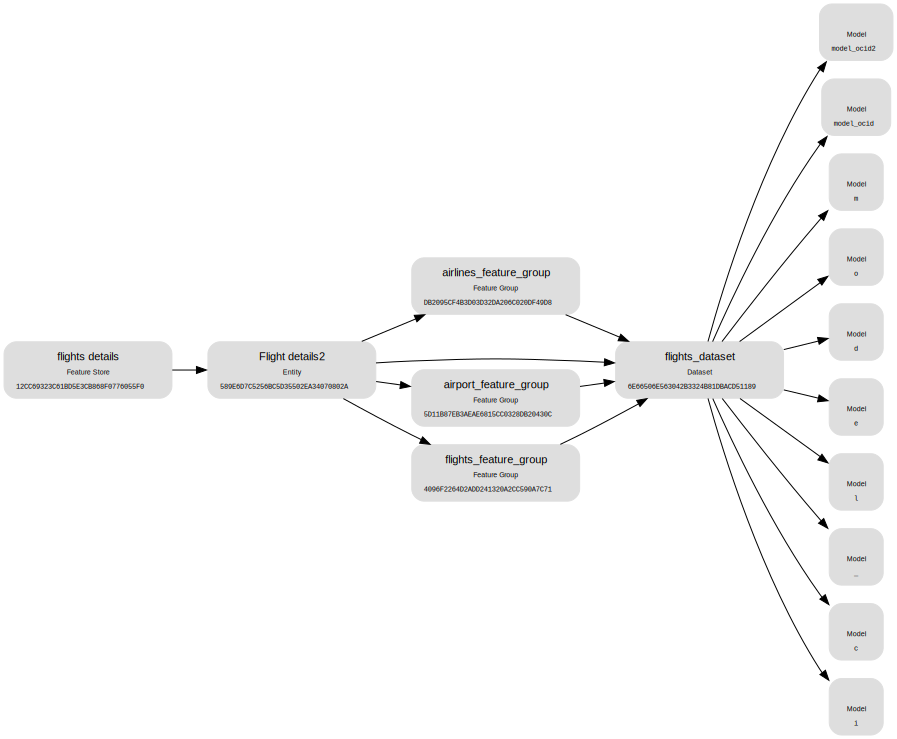

In [51]:
updated_dataset.show()

In [46]:
dataset.profile().show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|       lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
| delta|25133d3a-d4b2-449...|b2e98e1ea735160bd...|       null|file:/Users/kshit...|2023-05-24 16:36:...|2023-05-24 16:36:41|              []|       8|      32727|        {}|               1|               2|[appendOnly, inva...|
+------+--------------------+--------------------+-----------+--------------------+-

In [47]:
dataset.preview().show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|AIRPORT|CITY|STATE|COUNTRY|LATITUDE|LONGITUDE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|2015|    1|  1|          4|     EV|         4354|           MKE|                IAH|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     US|          425|           PDX|                PHX|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     AA|           89|           IAH|                MIA|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     DL|         2099|           BNA|                DTW|     null|   null|null| null|   null|    null|     null|
|2015|

<a id="sql_query"></a>
### 3.8  Freeform SQL query
Feature store provides a way to query feature store using free flow query. User need to mention `entity id` as the database name and `feature group name` as the table name to query feature store. This functionality can be useful if you need to express more complex queries for your use case

In [48]:
entity_id = entity.id

sql = (f"SELECT flights_feature_group.*, airport_feature_group.IATA_CODE "
       f"FROM `{entity_id}`.flights_feature_group flights_feature_group "
       f"LEFT JOIN `{entity_id}`.airport_feature_group airport_feature_group "
       f"ON flights_feature_group.ORIGIN_AIRPORT=airport_feature_group.IATA_CODE")

In [49]:
feature_store.sql(sql).show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+
|2015|    1|  1|          4|     DL|         1450|           LAS|                MSP|      LAS|
|2015|    1|  1|          4|     UA|         1545|           LAX|                IAH|      LAX|
|2015|    1|  1|          4|     AS|          130|           FAI|                SEA|      FAI|
|2015|    1|  1|          4|     NK|          597|           MSP|                FLL|      MSP|
|2015|    1|  1|          4|     US|          413|           LAS|                CLT|      LAS|
|2015|    1|  1|          4|     AA|         2392|           DEN|                MIA|      DEN|
|2015|    1|  1|          4|     NK|          168|           PHX|                ORD|      PHX|
|2015|    1|  1|          4|     AA|    

In [52]:
feature_store_yaml = """
apiVersion: v1
kind: featureStore
spec:
  displayName: Flights feature store
  compartmentId: "ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa"
  offlineConfig:
    metastoreId: "ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxyap7tizm4gscwz7amu7dixz7ml3mtesqzzwwg3urvvdgua"

  entity: &flights_entity
    - kind: entity
      spec:
        name: Flights

  featureGroup:
    - kind: featureGroup
      spec:
        entity: *flights_entity
        name: flights_feature_group
        primaryKeys:
          - IATA_CODE
        inputFeatureDetails:
          - featureType: STRING
            name: IATA_CODE
            orderNumber: 1
          - featureType: STRING
            name: AIRPORT
            orderNumber: 2
          - featureType: STRING
            name: CITY
            orderNumber: 3
          - featureType: STRING
            name: STATE
            orderNumber: 4
          - featureType: STRING
            name: COUNTRY
            orderNumber: 5
          - featureType: FLOAT
            name: LATITUDE
            orderNumber: 6
          - featureType: FLOAT
            name: LONGITUDE
            orderNumber: 7
    - kind: featureGroup
      spec:
        entity: *flights_entity
        name: airlines_feature_group
        primaryKeys:
          - IATA_CODE
        inputFeatureDetails:
          - featureType: STRING
            name: IATA_CODE
            orderNumber: 1
          - featureType: STRING
            name: AIRPORT
            orderNumber: 2
          - featureType: STRING
            name: CITY
            orderNumber: 3
          - featureType: STRING
            name: STATE
            orderNumber: 4
          - featureType: STRING
            name: COUNTRY
            orderNumber: 5
          - featureType: FLOAT
            name: LATITUDE
            orderNumber: 6
          - featureType: FLOAT
            name: LONGITUDE
            orderNumber: 7

    - kind: featureGroup
      spec:
        entity: *flights_entity
        name: airport_feature_group
        primaryKeys:
          - IATA_CODE
        inputFeatureDetails:
          - featureType: STRING
            name: IATA_CODE
            orderNumber: 1
          - featureType: STRING
            name: AIRLINE
            orderNumber: 2
  dataset:
    - kind: dataset
      spec:
        name: flights_dataset
        entity: *flights_entity
        description: "Dataset for flights"
        query: 'SELECT flight.IATA_CODE, flight.AIRPORT FROM flights_feature_group flight'
"""

In [53]:
registrar = FeatureStoreRegistrar.from_yaml(yaml_string=feature_store_yaml)
registrar.create()

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully created 1 entities, 0 transformations, 3 feature groups and 1 datasets


(
 kind: featurestore
 spec:
   compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
   dataset:
   - kind: dataset
     spec:
       description: Dataset for flights
       entity: &id001
       - kind: entity
         spec:
           name: Flights
       name: flights_dataset
       query: SELECT flight.IATA_CODE, flight.AIRPORT FROM flights_feature_group flight
   displayName: Flights feature store
   entity: *id001
   featureGroup:
   - kind: featureGroup
     spec:
       entity: *id001
       inputFeatureDetails:
       - featureType: STRING
         name: IATA_CODE
         orderNumber: 1
       - featureType: STRING
         name: AIRPORT
         orderNumber: 2
       - featureType: STRING
         name: CITY
         orderNumber: 3
       - featureType: STRING
         name: STATE
         orderNumber: 4
       - featureType: STRING
         name: COUNTRY
         orderNumber: 5
       - featureType: FLOAT
         name: LATITUDE
   

<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)